In [1]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
iris = datasets.load_iris()

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
Y = iris.target
X = iris.data
class_labels = iris.target_names
X_variable_names = iris.feature_names

What is the rate of missing data?

In [5]:
np.mean(np.isnan(X)) #thankkfully there's no missing data

0.0

### Train-Test Split
Save a small portion of the X and Y data sets for testing, and to eventually passing to the API

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .05, random_state = 42)

### Data Exploration

In [7]:
print(f"Class labels are: {class_labels}")
print(f"Feature are: {X_variable_names}")

Class labels are: ['setosa' 'versicolor' 'virginica']
Feature are: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [8]:
print(np.bincount(Y_train)) #well balanced
print(X_train.shape)

[48 46 48]
(142, 4)


### Visualization
Visualize the training data

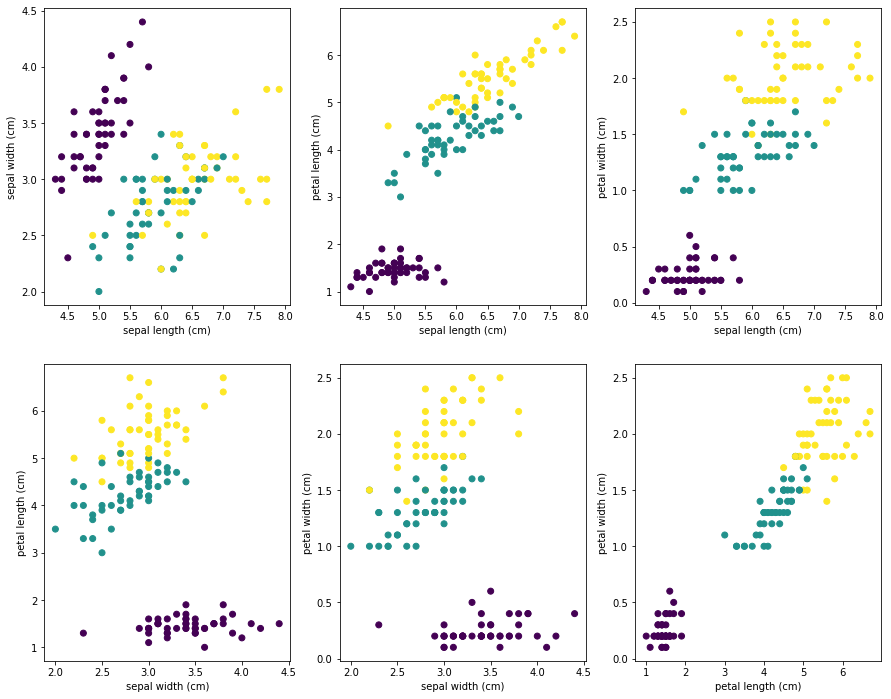

In [9]:
plt.figure(figsize = [15.0,12.0])

plt.subplot(2,3,1)
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train)
plt.xlabel(X_variable_names[0])
plt.ylabel(X_variable_names[1])

plt.subplot(2,3,2)
plt.scatter(X_train[:,0],X_train[:,2],c=Y_train)
plt.xlabel(X_variable_names[0])
plt.ylabel(X_variable_names[2])

plt.subplot(2,3,3)
plt.scatter(X_train[:,0],X_train[:,3],c=Y_train)
plt.xlabel(X_variable_names[0])
plt.ylabel(X_variable_names[3])

plt.subplot(2,3,4)
plt.scatter(X_train[:,1],X_train[:,2],c=Y_train)
plt.xlabel(X_variable_names[1])
plt.ylabel(X_variable_names[2])

plt.subplot(2,3,5)
plt.scatter(X_train[:,1],X_train[:,3],c=Y_train)
plt.xlabel(X_variable_names[1])
plt.ylabel(X_variable_names[3])


plt.subplot(2,3,6)
plt.scatter(X_train[:,2],X_train[:,3],c=Y_train)
plt.xlabel(X_variable_names[2])
plt.ylabel(X_variable_names[3])


plt.show()


There's some noise in the process, but not a terribly large amount.

## Estimating Models
The idea is to create seeral models, and then an enseamble all of them.

The plan is to create and evaluate the following models:

* Naive Bayes,
* Random Forest,
* Support Vector Machine (with a normal kernel),  

and then an ensemble of all of the above.

### Naive Bayes
This model estimates the parameters of a normal distribution for the marginal distributions of our three variables for each type of iris.  The model then multiplies the vlue of the estimated normal distribution of each variable together for each iris category as well as the relative prevelance of each iris type, and uses the greatest product to pick a most likely iris variety.
It is "naive" in that it ignores correlations/dependencies between individual features/variables.

In [10]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, Y_train)
print("Training subset accuracy is: ", clf_gnb.score(X_train,Y_train))
print("Testing subset accuracy is: ", clf_gnb.score(X_test,Y_test))

Training subset accuracy is:  0.9577464788732394
Testing subset accuracy is:  1.0


### Random Forest (classifier)
Random forest is very nealy a bagged tree classifier.  That is, it creates an ensemble of individual tree classifiers (defaulting to 100 individual trees) from boostrapped samples.  The difference being that random forest has the additional random behavior of predicting cuts on each node from a random sample of available explanatory variables--we only have three possible variables/features, so this may have minimal effect.
The default behavior is to examine `sqrt(n_features)` for a valid split.

In [11]:
clf_rf = RandomForestClassifier(oob_score = True)
clf_rf.fit(X_train,Y_train)
print("The training acccuracy is",clf_rf.score(X_train,Y_train))
print("The out of bag-score (accuracy) is ",clf_rf.oob_score_)
print("Testing subset accuracy is: ", clf_rf.score(X_test,Y_test))

The training acccuracy is 1.0
The out of bag-score (accuracy) is  0.9436619718309859
Testing subset accuracy is:  1.0


Training accuracy is even higher, which is to be expected given that RF is more flexible than NB.  
Note the `oob` of "out of bag" score is unique to boostrapped models, which is produced by running individual training records from outside of a given boostrap sample through a given model (a tree in this case), and being evaluated.

### Support Vector Machine
I've never found an especially satisfactory explanation of how SVM's work.  The phrase often bandied about is that of "the kernel trick".  Each kernel seems to have its own interpretation.  We're using the normal kernel (or RBF kernel in sci-kit learn's parlance).  The best I can figure out, the SVM produces a probability density around each training example.  These densities are combined across all training records to produce a likely outcome for a given value space.

#### Finding optimum hyperparameter values
We don't wish to overfit, so we must find the optimum hyperparameters.  The plan is to use the normal kernel SVM, a.k.a. radial basis function.  This requires one to establish hyperparameters for two values: the variance-ish parameter (`gamma`), and the overfitting parameter (`C`).

In [12]:
clf_svm = SVC(kernel = 'rbf')
param_vals =  {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001]}
grid_search_SVC = GridSearchCV(clf_svm, param_grid = param_vals)
grid_search_SVC.fit(X_train,Y_train)
print(grid_search_SVC.best_params_)

{'C': 100, 'gamma': 0.01}


Okay.  We have our hyper parameters for the support vector machine, and they are not on the edge of our parameter space.

In [13]:
clf_svm = SVC(
    kernel = 'rbf',
    C = grid_search_SVC.best_params_["C"],
    gamma = grid_search_SVC.best_params_["gamma"],
    probability = True
)
clf_svm.fit(X_train,Y_train)
print("Training subset accuracy is: ", clf_svm.score(X_train,Y_train))
print("Testing subset accuracy is: ", clf_svm.score(X_test,Y_test))

Training subset accuracy is:  0.9859154929577465
Testing subset accuracy is:  1.0


(The reason for the `probability = True` is necessary for the next step).  
Better than Naive Bayes.  Not quite as good as the random forest.

### Ensemble model
The idea here is to combine all of the models above into a single estimator.

In [14]:
eclf = VotingClassifier(
    estimators = [("nb",clf_gnb),("rf",clf_rf),("svm",clf_svm)]
    , voting = "soft"
)

eclf.fit(X_train,Y_train)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier(oob_score=True)),
                             ('svm', SVC(C=100, gamma=0.01, probability=True))],
                 voting='soft')

The `soft` voting parameter combines the output probability vectors of the individual estimators.  A `hard` estimator would go on majority rule of predicted class from each estimator.

In [15]:
print("Training subset accuracy is: ",eclf.score(X_train,Y_train))
print("Testing subset accuracy is: ",eclf.score(X_test,Y_test))

Training subset accuracy is:  0.9647887323943662
Testing subset accuracy is:  1.0


The Naive Bayes seems to be dragging the ensemble predictions down....  
I suspect we got lucky in the initial train-test split in avoiding all of the ambiguous or borderline species.

In [16]:
test_preds = eclf.predict(X_test)
print(test_preds)
print(eclf.predict_proba(X_test))
print(type(test_preds))

[1 0 2 1 1 0 1 2]
[[1.66112255e-03 9.68548551e-01 2.97903265e-02]
 [9.80233174e-01 1.54664020e-02 4.30042446e-03]
 [4.80898237e-04 1.80937136e-05 9.99501008e-01]
 [2.48059839e-03 9.58367750e-01 3.91516517e-02]
 [1.58657430e-03 8.72074222e-01 1.26339204e-01]
 [9.86514931e-01 9.36638484e-03 4.11868402e-03]
 [1.29968939e-02 9.83698198e-01 3.30490780e-03]
 [3.80922559e-03 3.23209831e-02 9.63869791e-01]]
<class 'numpy.ndarray'>


In [17]:
np.mean(Y_test == test_preds)

1.0

In [18]:
#predicted class labels actual labels
print(class_labels[test_preds].tolist())
print(class_labels[Y_test].tolist())


['versicolor', 'setosa', 'virginica', 'versicolor', 'versicolor', 'setosa', 'versicolor', 'virginica']
['versicolor', 'setosa', 'virginica', 'versicolor', 'versicolor', 'setosa', 'versicolor', 'virginica']


Even better!

## Saving the models  
Save the model for the API, class names, feature names, and the test data.

In [19]:
X_test_df = pd.DataFrame(X_test,columns = X_variable_names, index = None)
Y_test_df = pd.DataFrame(Y_test, index = None, columns = None)

In [20]:
dump(clf_gnb,"gnb.joblib")
dump(clf_rf,"rf.joblib")
dump(clf_svm,"svm.joblib")

dump(eclf,"ensemble.joblib")

dump(class_labels,"class_labels.joblib")
dump(X_variable_names,"X_variable_names.joblib")

X_test_df.to_csv("X_test.csv", index = False)
#The method below outputs the appropriate format, i.e. each field/variable/feature as a list.
with open("X_test.json","w") as file:
    file.write(pd.io.json.dumps(X_test_df.to_dict(orient = "list")))
    
Y_test_df.to_csv("Y_test.csv", header = None, index = False)
Y_test_df.to_json("Y_test.json", orient = "records")

In [21]:
X_test_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.1,2.8,4.7,1.2
1,5.7,3.8,1.7,0.3
2,7.7,2.6,6.9,2.3
3,6.0,2.9,4.5,1.5
4,6.8,2.8,4.8,1.4
5,5.4,3.4,1.5,0.4
6,5.6,2.9,3.6,1.3
7,6.9,3.1,5.1,2.3
